In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Medium Blogs/Reviews.csv')
print(df.shape)
df.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Filtering out neutral reviews.

In [4]:
filtered_data = df[df['Score'] != 3]
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Removing duplicates from the dataset.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

## Preprocessing the data.
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags

2. Remove any punctuations or limited set of special characters like , or .   or # etc.

3. Check if the word is made up of english letters and is not alpha-numeric

4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5. Convert the word to lowercase
6. Remove Stopwords

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:30<00:00, 2415.38it/s]


## Vectorizing the text data.

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Instansiating tokenizer.
t = Tokenizer()
# Preprocessed_reviews contains all the cleaned reviews.
t.fit_on_texts(preprocessed_reviews)
vocab_size = len(t.word_index) + 1
# integer encode the reviews.
encoded_reviews = t.texts_to_sequences(preprocessed_reviews)
# pad reviews to a max length of 150 words
max_length = 150
padded_reviews = pad_sequences(encoded_reviews, maxlen=max_length, padding='post')

In [15]:
print(padded_reviews[0])

[21845    22  1413    77   362  4884  4426 26581  1256  3259   503    79
  7342 11910  1254 30623  2231 22781  3832    12   152  1611  1413 16776
 23796  1467  1413  1778  2285   362    64   237 26581  3331  1926     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [18]:
x_train = padded_reviews[0:int(0.9*len(padded_reviews))]
x_test = padded_reviews[int(0.9*len(padded_reviews)):len(padded_reviews)]
print(x_train.shape)
print(x_test.shape)

(327753, 150)
(36418, 150)


In [19]:
import numpy as np
y_train = np.array(list(final['Score'].iloc[0:int(0.9*len(padded_reviews))].values))
y_test = np.array(list(final['Score'].iloc[int(0.9*len(padded_reviews)):len(padded_reviews)].values))
print(y_train.shape, y_test.shape)

(327753,) (36418,)


## Defining the model.

In [44]:
from keras.models import Sequential
from keras.layers import Input, CuDNNLSTM, Dense
from keras.layers.embeddings import Embedding
import keras.backend as K

model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=max_length))
# While passing output to next LSTM layer set return_sequence to Ture.
model.add(CuDNNLSTM(128, return_sequences=True)) 
model.add(CuDNNLSTM(128))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss=['binary_crossentropy'] , optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 32)           3736800   
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 150, 128)          82944     
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 3,956,001
Trainable params: 3,956,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=5, patience=5)

In [46]:
history = model.fit(x_train, y_train, epochs=50, batch_size=1024, validation_split=0.1, callbacks=[es] )

Train on 294977 samples, validate on 32776 samples
Epoch 1/50
294977/294977 [==============================] - 22s 76us/step - loss: 0.4339 - accuracy: 0.8460 - val_loss: 0.4549 - val_accuracy: 0.8302
Epoch 2/50
294977/294977 [==============================] - 22s 74us/step - loss: 0.4165 - accuracy: 0.8460 - val_loss: 0.4416 - val_accuracy: 0.8302
Epoch 3/50
294977/294977 [==============================] - 22s 74us/step - loss: 0.4165 - accuracy: 0.8460 - val_loss: 0.4421 - val_accuracy: 0.8302
Epoch 4/50
294977/294977 [==============================] - 22s 74us/step - loss: 0.4172 - accuracy: 0.8460 - val_loss: 0.4428 - val_accuracy: 0.8302
Epoch 5/50
294977/294977 [==============================] - 22s 74us/step - loss: 0.4175 - accuracy: 0.8460 - val_loss: 0.4437 - val_accuracy: 0.8302
Epoch 6/50
294977/294977 [==============================] - 22s 74us/step - loss: 0.4214 - accuracy: 0.8460 - val_loss: 0.4570 - val_accuracy: 0.8302
Epoch 7/50
294977/294977 [=======================

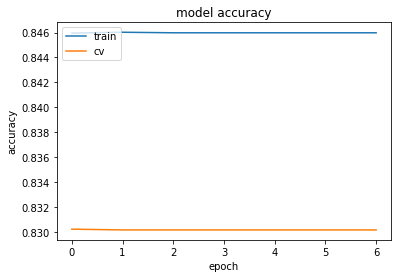

In [47]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

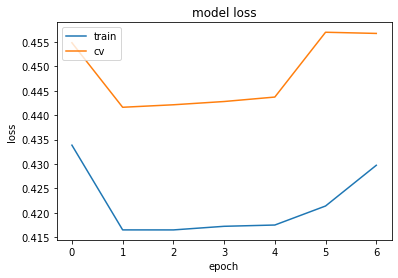

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

In [0]:
prob = model.predict(x_test)
y_pred = []
for i in range(prob.shape[0]):
  if(prob[i][0]>=0.5):
    y_pred.append(1)
  else:
    y_pred.append(0)

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6111
           1       0.83      1.00      0.91     30307

    accuracy                           0.83     36418
   macro avg       0.42      0.50      0.45     36418
weighted avg       0.69      0.83      0.76     36418



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Architecture using bidirectional LSTMS

In [51]:
from keras.models import Sequential
from keras.layers import Input, CuDNNLSTM, Dense, Bidirectional
from keras.layers.embeddings import Embedding
import keras.backend as K

model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=max_length))
# While passing output to next LSTM layer set return_sequence to Ture.
model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True))) 
model.add(Bidirectional(CuDNNLSTM(128)))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss=['binary_crossentropy'] , optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 32)           3736800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 150, 256)          165888    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               395264    
_________________________________________________________________
dense_9 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 4,306,209
Trainable params: 4,306,209
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(x_train, y_train, epochs=50, batch_size=1024, validation_split=0.1, callbacks=[es] )

Train on 294977 samples, validate on 32776 samples
Epoch 1/50
294977/294977 [==============================] - 52s 176us/step - loss: 0.2414 - accuracy: 0.9063 - val_loss: 0.2022 - val_accuracy: 0.9188
Epoch 2/50
294977/294977 [==============================] - 51s 173us/step - loss: 0.1581 - accuracy: 0.9399 - val_loss: 0.1838 - val_accuracy: 0.9254
Epoch 3/50
294977/294977 [==============================] - 51s 173us/step - loss: 0.1331 - accuracy: 0.9504 - val_loss: 0.1752 - val_accuracy: 0.9309
Epoch 4/50
294977/294977 [==============================] - 51s 173us/step - loss: 0.1163 - accuracy: 0.9573 - val_loss: 0.1990 - val_accuracy: 0.9292
Epoch 5/50
294977/294977 [==============================] - 51s 173us/step - loss: 0.1010 - accuracy: 0.9638 - val_loss: 0.1909 - val_accuracy: 0.9253
Epoch 6/50
294977/294977 [==============================] - 51s 173us/step - loss: 0.0898 - accuracy: 0.9679 - val_loss: 0.2376 - val_accuracy: 0.9212
Epoch 7/50
294977/294977 [=================

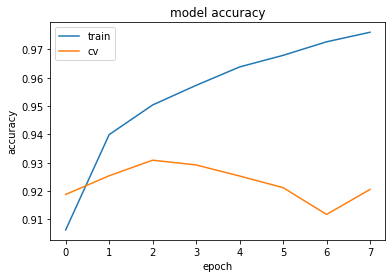

In [55]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

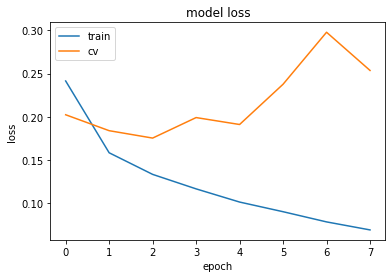

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

In [0]:
prob = model.predict(x_test)

In [0]:
y_pred = []
for i in range(prob.shape[0]):
  if(prob[i][0]>=0.5):
    y_pred.append(1)
  else:
    y_pred.append(0)

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      6111
           1       0.95      0.95      0.95     30307

    accuracy                           0.92     36418
   macro avg       0.85      0.86      0.85     36418
weighted avg       0.92      0.92      0.92     36418

